In [1]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt

from pprint import pprint
from Algorithms.ddpg import config

# 0. Plot Setting

In [2]:
import seaborn as sb
import matplotlib

sb.set_style('whitegrid')

FONTSIZE = 10
matplotlib.rcParams["figure.figsize"] = (10, 5)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.titlesize"] = FONTSIZE
matplotlib.rcParams["legend.fontsize"] = FONTSIZE
matplotlib.rcParams["xtick.labelsize"] = FONTSIZE
matplotlib.rcParams["ytick.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.labelsize"] = FONTSIZE
matplotlib.rcParams["axes.titlesize"] = FONTSIZE
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0.1
matplotlib.rcParams["lines.linewidth"] = 2
matplotlib.rcParams["axes.linewidth"] = 1.6

# P&L Training

## 1. Load Config

In [3]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('tmp_config.yaml')
# env_kwargs, model_kwargs, learn_kwargs = config.load_config('../logs/tb_logs/ddpg_220616-2239_1_ddpg_pnl/config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [4]:
ntb_mode = False
double_ddpg = True

env_kwargs.update({
    'reward_fn': 'mean var',
    'reward_fn_kwargs': {},
    'reward_mode': 'pnl'
})

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'mean_coeff': 1.0,
    'std_coeff': 1.2 if ntb_mode else 1.0,
})

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,
    'double_ddpg': double_ddpg,
})

learn_kwargs.update({
    'total_timesteps': 2000
})

# del model_kwargs['std_coeff']

if ntb_mode:
    actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
    critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32],
                     'qf': [(nn.BatchNorm1d, 'bn'), 16],
                     'qf2': [(nn.BatchNorm1d, 'bn'), 2]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

else:
    model_kwargs['policy_kwargs'].update({
        'net_arch': [],
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 2,
        'net_arch': [32, 64]
    })

model_kwargs['policy_kwargs']['one_asset'] = (env_kwargs['n_assets']==1)

In [5]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

env 'BSMarket was created!
model_kwargs['env']: <BSMarket instance>
env 'BSMarket was created!
learn_kwargs['eval_env']: <BSMarketEval instance>
learn_kwargs['tb_log_name']: ddpg_220617-2028
learn_kwargs['eval_log_path']: ../logs/tb_logs/ddpg_220617-2028_1


In [6]:
pprint(env_kwargs)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 0.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 1000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'pnl',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [7]:
pprint(model_kwargs)

{'action_noise': NormalActionNoise(mu=0.0, sigma=0.1),
 'batch_size': 15,
 'buffer_size': 300,
 'create_eval_env': False,
 'device': 'auto',
 'env': <Env.env.BSMarket object at 0x000001811D43F220>,
 'gamma': 0.99,
 'gradient_steps': -1,
 'learning_rate': <function lr_schedule at 0x000001811D26E820>,
 'learning_starts': 300,
 'mean_coeff': 1.0,
 'optimize_memory_usage': False,
 'policy': <class 'Algorithms.ddpg.policies.DoubleDDPGPolicy'>,
 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   'actor_net_kwargs': None,
                   'critic_net_kwargs': None,
                   'double_ddpg': True,
                   'features_extractor_class': <class 'Env.feature_extractor.MarketObsExtractor'>,
                   'features_extractor_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                                                 'features_in': 4,
                                                 'features_out': 2,
  

In [8]:
pprint(learn_kwargs)

{'callback': <Algorithms.ddpg.callbacks.ReportCallbacks object at 0x000001811D277CA0>,
 'eval_env': <Env.env.BSMarketEval object at 0x000001811D43F640>,
 'eval_freq': 30,
 'eval_log_path': '../logs/tb_logs/ddpg_220617-2023_1',
 'log_interval': 30,
 'n_eval_episodes': 1,
 'reset_num_timesteps': True,
 'tb_log_name': 'ddpg_220617-2023',
 'total_timesteps': 2000}


## 2. Make env, model

In [9]:
from Algorithms.ddpg import DoubleDDPG
# from Algorithms.ddpg.double_ddpg import DDPG

# model = DoubleDDPG(**model_kwargs)
model = DoubleDDPG(**model_kwargs)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [10]:
model.policy

DoubleDDPGPolicy(
  (actor): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=4, out_features=32, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
        (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): Linear(in_features=64, out_features=2, bias=True)
        (8): ReLU()
      )
    )
    (mu): Sequential(
      (0): Linear(in_features=2, out_features=1, bias=True)
      (1): Tanh()
    )
    (flatten): Flatten(start_dim=-2, end_dim=-1)
  )
  (actor_target): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, tr

## 3. Learning

In [11]:
model = model.learn(**learn_kwargs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/tb_logs\ddpg_220617-1922_1
[Training Start]
Eval num_timesteps=30, episode_reward=-0.03 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0251  |
| time/              |          |
|    total timesteps | 30       |
---------------------------------
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.03 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0257  |
| time/              |          |
|    total timesteps | 60       |
---------------------------------
Eval num_timesteps=90, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mea

In [12]:
config.save_config(f'{learn_kwargs["eval_log_path"]}/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarket instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.ddpg.callbacks.ReportCallbacks object at 0x000001D17BDC0370> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/ddpg_220617-1922_1/config.yaml was saved.


## 4. P&L Evaluation

In [42]:
model = model.load('../logs/tb_logs/ddpg_220617-1922_1'+'/best_model')
# model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
print(learn_kwargs['eval_log_path'] + '/best_model')

../logs/tb_logs/ddpg_220617-1922_1/best_model


In [6]:
eval_env = learn_kwargs['eval_env']
eval_env.reward_mode = 'pnl'

In [7]:
import numpy as np

zero_pnl = np.load('best_results/zero_pnl.npy')
zero_cash = np.load('best_results/zero_cash.npy')
random_pnl = np.load('best_results/random_pnl.npy')
random_cash = np.load('best_results/random_cash.npy')

rl_pnl = np.load('best_results/pnl_train/rl_pnl.npy')
rl_cash = np.load('best_results/pnl_train/rl_cash.npy')

ntb_pnl = np.load('best_results/pnl_train/ntb_pnl.npy')
ntb_cash = np.load('best_results/pnl_train/ntb_cash.npy')

In [60]:
# def env_eval(env, model=None, reward_mode='cash', n=100):
#     tmp = env.reward_mode
#     env.reward_mode = reward_mode
#     result = []
#     for _ in range(n):
#         obs = env.reset()
#         reward, done, info = 0, False, {}
#         total_raw_reward = 0
#         while not done:
#             if model:
#                 action, _ = model.predict(obs, deterministic=False)
#             else:
#                 action = env.action_space.sample()
#             obs, reward, done, info = env.step(action)
#             total_raw_reward += info['raw_reward']
#         result.append(total_raw_reward)
#
#     env.reward_mode = tmp
#     return np.mean(result, axis=0)
#
# def action_inspect(env, model=None, reward_mode='cash'):
#     tmp = env.reward_mode
#     env.reward_mode = reward_mode
#     obs = env.reset()
#     reward, done, info = 0, False, {}
#     actions = []
#     for i in range(30):
#         while not done:
#             if model:
#                 action, _ = model.predict(obs, deterministic=False)
#             else:
#                 action = env.action_space.sample()
#             obs, reward, done, info = env.step(action)
#             actions.append(action)
#     env.reward_mode = tmp
#     return np.mean(actions), np.min(actions), np.max(actions)

In [8]:
# ntb_pnl = np.mean([env_eval(eval_env, model, 'pnl') for _ in range(100)], axis=0)
# ntb_cash = np.mean([env_eval(eval_env, model, 'cash') for _ in range(100)], axis=0)

# ntb_pnl = env_eval(eval_env, model, 'pnl', 100)
# ntb_cash = env_eval(eval_env, model, 'cash', 100)

delta_pnl = eval_env.delta_eval('pnl', 100)
delta_cash = eval_env.delta_eval('cash', 100)

In [62]:
# np.save('best_results/zero_pnl', zero_pnl)
# np.save('best_results/zero_cash', zero_cash)

# np.save('best_results/pnl_train/rl_pnl', ntb_pnl)
# np.save('best_results/pnl_train/rl_cash', ntb_cash)

# np.save('best_results/pnl_train/ntb_pnl', ntb_pnl)
# np.save('best_results/pnl_train/ntb_cash', ntb_cash)

In [9]:
def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return [mean - 0.02 * std , mean, std]

def sharpe_ratio(pnl):
    return pnl.mean()/pnl.std()

def var(pnl, ratio):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return losses[boundary]

def cvar(pnl, ratio=0.95):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return np.mean(losses[boundary:], axis=-1)

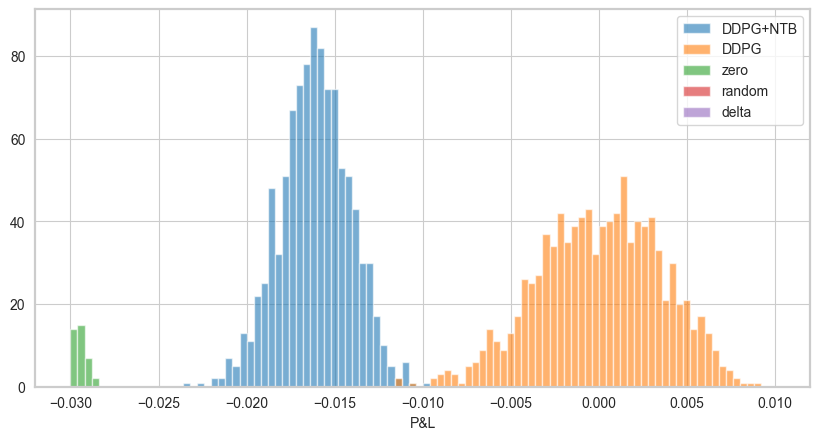

ntb pnl: 		[-0.0162 -0.0161  0.002 ]
rl pnl: 		[-0.      0.0001  0.0035]
zero pnl: 		[-0.0322 -0.0322  0.0013]
random pnl: 	[-0.2134 -0.2134  0.0038]
delta pnl: 		[-0.0547 -0.0547  0.0018]

ntb cvar:		0.02036
rl cvar:		0.00742
zero cvar:		0.03489
random cvar:	0.22131
delta cvar:		0.05825



In [17]:
plt_kwargs = {'bins': 100,
              'range': (-0.03, 0.01),
              'alpha': 0.6}

plt.xlabel('P&L')
plt.hist(ntb_pnl,**plt_kwargs, label='DDPG+NTB')
plt.hist(rl_pnl, **plt_kwargs, label='DDPG')
plt.hist(zero_pnl,**plt_kwargs, label='zero')
plt.hist(random_pnl,**plt_kwargs, label='random')
plt.hist(delta_pnl,**plt_kwargs, label='delta')
plt.legend()
plt.show()

print(f'ntb pnl: \t\t{np.round(pnl_reward(ntb_pnl), 4)}')
print(f'rl pnl: \t\t{np.round(pnl_reward(rl_pnl), 4)}')
print(f'zero pnl: \t\t{np.round(pnl_reward(zero_pnl), 4)}')
print(f'random pnl: \t{np.round(pnl_reward(random_pnl), 4)}')
print(f'delta pnl: \t\t{np.round(pnl_reward(delta_pnl), 4)}')
print()

print(f'ntb cvar:\t\t{cvar(ntb_pnl):.5f}')
print(f'rl cvar:\t\t{cvar(rl_pnl):.5f}')
print(f'zero cvar:\t\t{cvar(zero_pnl):.5f}')
print(f'random cvar:\t{cvar(random_pnl):.5f}')
print(f'delta cvar:\t\t{cvar(delta_pnl):.5f}')
print()

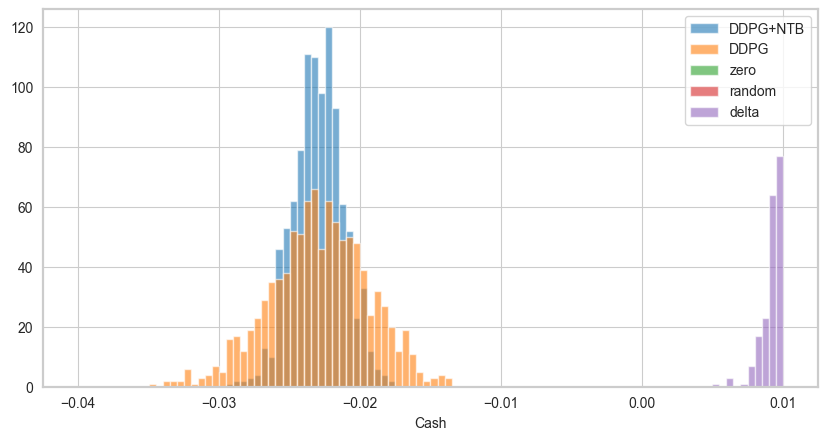

ntb cash: 		[-0.023  -0.023   0.0018]
rl cash: 		[-0.023  -0.0229  0.0035]
zero cash: 		[0.0348 0.0349 0.0024]
random cash: 	[0.1701 0.1702 0.0036]
delta cash: 	[0.0113 0.0113 0.0015]

ntb cvar:		0.02667
rl cvar:		0.03066
zero cvar:		-0.02970
random cvar:	-0.16243
delta cvar:		-0.00819



In [18]:
plt_kwargs = {'bins': 100,
              'range': (-0.04, 0.01),
              'alpha': 0.6}

plt.xlabel('Cash')
plt.hist(ntb_cash,**plt_kwargs, label='DDPG+NTB')
plt.hist(rl_cash, **plt_kwargs, label='DDPG')
plt.hist(zero_cash,**plt_kwargs, label='zero')
plt.hist(random_cash,**plt_kwargs, label='random')
plt.hist(delta_cash,**plt_kwargs, label='delta')
plt.legend()
plt.show()

print(f'ntb cash: \t\t{np.round(pnl_reward(ntb_cash), 4)}')
print(f'rl cash: \t\t{np.round(pnl_reward(rl_cash), 4)}')
print(f'zero cash: \t\t{np.round(pnl_reward(zero_cash), 4)}')
print(f'random cash: \t{np.round(pnl_reward(random_cash), 4)}')
print(f'delta cash: \t{np.round(pnl_reward(delta_cash), 4)}')
print()

print(f'ntb cvar:\t\t{cvar(ntb_cash):.5f}')
print(f'rl cvar:\t\t{cvar(rl_cash):.5f}')
print(f'zero cvar:\t\t{cvar(zero_cash):.5f}')
print(f'random cvar:\t{cvar(random_cash):.5f}')
print(f'delta cvar:\t\t{cvar(delta_cash):.5f}')
print()

In [16]:
def delta_eval2(env, reward_mode='cash', n=1):
    tmp = env.reward_mode
    env.reward_mode = reward_mode

    result = []
    for _ in range(n):
        obs = env.reset()
        reward, done, info = 0, False, {}
        total_raw_reward = 0
        i = 0
        while not done:
            action = env.delta[i+1].copy()
            obs, reward, done, info = env.step(action)
            total_raw_reward += info['raw_reward']
            i += 1
        result.append(total_raw_reward)

    env.reward_mode = tmp

    return np.mean(result, axis=0)

delta2_pnl = delta_eval2(eval_env, 'pnl', 100)
delta2_cash = delta_eval2(eval_env, 'cash', 100)

In [26]:
# np.save('best_results/pnl_train/ntb_pnl', ntb_pnl)
# np.save('best_results/pnl_train/ntb_cash', ntb_cash)

# Cash Training

## 1. Load Config

In [3]:
env_kwargs, model_kwargs, learn_kwargs = config.load_config('tmp_config.yaml')

env 'BSMarket was created!
env 'BSMarket was created!


In [4]:
ntb_mode = False
double_ddpg = True

env_kwargs.update({
    'reward_fn': 'mean var',
    'reward_fn_kwargs': {},
    'reward_mode': 'cash'
})

model_kwargs.update({
    'buffer_size': 300,
    'learning_starts': 300,
    'batch_size': 15,
    'mean_coeff': 1.0,
    'std_coeff': 1.2
})

model_kwargs['policy_kwargs'].update({
    'ntb_mode': ntb_mode,
    'double_ddpg': double_ddpg,
})

learn_kwargs.update({
    'total_timesteps': 2500
})

# del model_kwargs['std_coeff']

if ntb_mode:
    actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
    critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [(nn.BatchNorm1d, 'bn'), 32, 32],
                     'qf': [(nn.BatchNorm1d, 'bn'), 16],
                     'qf2': [(nn.BatchNorm1d, 'bn'), 2]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32]
    })

else:
    actor_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}
    critic_net_kwargs = {'bn_kwargs': {'num_features': env_kwargs['n_assets']}}

    model_kwargs['policy_kwargs'].update({
        'net_arch': {'pi': [32,],
                     'qf': [2,],
                     'qf2': [2,]},
        'actor_net_kwargs': actor_net_kwargs,
        'critic_net_kwargs': critic_net_kwargs,
    })

    model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
        'features_out': 64,
        'net_arch': [32, 64]
    })
    # model_kwargs['policy_kwargs'].update({
    #     'net_arch': [],
    # })
    #
    # model_kwargs['policy_kwargs']['features_extractor_kwargs'].update({
    #     'features_out': 2,
    #     'net_arch': [32, 32]
    # })

model_kwargs['policy_kwargs']['one_asset'] = (env_kwargs['n_assets']==1)

In [5]:
config.reconstruct_config(env_kwargs, model_kwargs, learn_kwargs)

env 'BSMarket was created!
model_kwargs['env']: <BSMarket instance>
env 'BSMarket was created!
learn_kwargs['eval_env']: <BSMarketEval instance>
learn_kwargs['tb_log_name']: ddpg_220617-1619
learn_kwargs['eval_log_path']: ../logs/tb_logs/ddpg_220617-1619_1


In [6]:
pprint(env_kwargs)

{'cost': 0.02,
 'dividend': 0.0,
 'drift': 0.0,
 'freq': 1,
 'gen_name': 'gbm',
 'init_price': 1.0,
 'maturity': 30,
 'n_assets': 1000,
 'payoff': 'european',
 'payoff_coeff': 1.0,
 'period_unit': 365,
 'reward_fn': 'mean var',
 'reward_fn_kwargs': {},
 'reward_mode': 'cash',
 'risk_free_interest': 0.0,
 'strike': 1.0,
 'volatility': 0.2}


In [7]:
pprint(model_kwargs)

{'action_noise': NormalActionNoise(mu=0.0, sigma=0.1),
 'batch_size': 15,
 'buffer_size': 300,
 'create_eval_env': False,
 'device': 'auto',
 'env': <Env.env.BSMarket object at 0x0000022ADC1A0610>,
 'gamma': 0.99,
 'gradient_steps': -1,
 'learning_rate': <function lr_schedule at 0x0000022ADC18E820>,
 'learning_starts': 300,
 'mean_coeff': 1.0,
 'optimize_memory_usage': False,
 'policy': <class 'Algorithms.ddpg.policies.DoubleDDPGPolicy'>,
 'policy_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                   'actor_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'critic_net_kwargs': {'bn_kwargs': {'num_features': 1000}},
                   'double_ddpg': True,
                   'features_extractor_class': <class 'Env.feature_extractor.MarketObsExtractor'>,
                   'features_extractor_kwargs': {'activation_fn': <class 'torch.nn.modules.activation.ReLU'>,
                                                 'features_in': 4,
    

In [8]:
pprint(learn_kwargs)

{'callback': <Algorithms.ddpg.callbacks.ReportCallbacks object at 0x0000022AA581C340>,
 'eval_env': <Env.env.BSMarketEval object at 0x0000022ADC1A01F0>,
 'eval_freq': 30,
 'eval_log_path': '../logs/tb_logs/ddpg_220617-1619_1',
 'log_interval': 30,
 'n_eval_episodes': 1,
 'reset_num_timesteps': True,
 'tb_log_name': 'ddpg_220617-1619',
 'total_timesteps': 2500}


In [9]:
print(model_kwargs['env'].reward_mode)
print(learn_kwargs['eval_env'].reward_mode)

cash
cash


## 2. Make env, model

In [10]:
from Algorithms.ddpg import DoubleDDPG
# from Algorithms.ddpg.double_ddpg import DDPG

# model = DoubleDDPG(**model_kwargs)
model = DoubleDDPG(**model_kwargs)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [11]:
model.policy

DoubleDDPGPolicy(
  (actor): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): Sequential(
        (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Linear(in_features=4, out_features=32, bias=True)
        (2): ReLU()
        (3): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Linear(in_features=32, out_features=64, bias=True)
        (5): ReLU()
        (6): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): Linear(in_features=64, out_features=64, bias=True)
        (8): ReLU()
      )
    )
    (mu): Sequential(
      (0): Linear(in_features=64, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=1, bias=True)
      (3): Tanh()
    )
    (flatten): Flatten(start_dim=-2, end_dim=-1)
  )
  (actor_target): CustomActor(
    (features_extractor): MarketObsExtractor(
      (layers): S

## 3. Learning

In [12]:
model = model.learn(**learn_kwargs)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ../logs/tb_logs\ddpg_220617-1619_1
[Training Start]
Eval num_timesteps=30, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0233  |
| time/              |          |
|    total timesteps | 30       |
---------------------------------
New best mean reward!
Eval num_timesteps=60, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | -0.0241  |
| time/              |          |
|    total timesteps | 60       |
---------------------------------
Eval num_timesteps=90, episode_reward=-0.02 +/- 0.00
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mea

KeyboardInterrupt: 

In [13]:
config.save_config(f'{learn_kwargs["eval_log_path"]}/config.yaml', env_kwargs, model_kwargs, learn_kwargs)

<BSMarket instance> will be save as name. env_kwargs not in kwargs!
<BSMarketEval instance> will be save as name. eval_env_kwargs not in kwargs!
<Algorithms.ddpg.callbacks.ReportCallbacks object at 0x000002831A9C9AF0> will be save as name. callback_kwargs not in kwargs!
../logs/tb_logs/ddpg_220617-1517_1/config.yaml was saved.


## 4. P&L Evaluation

In [43]:
model = model.load(learn_kwargs['eval_log_path'] + '/best_model')
print(learn_kwargs['eval_log_path'] + '/best_model')

../logs/tb_logs/ddpg_220617-1517_1/best_model


In [15]:
eval_env = learn_kwargs['eval_env']
eval_env.reward_mode = 'pnl'

In [16]:
import numpy as np

pnl_rl_pnl = np.load('best_results/pnl_train/rl_pnl.npy')
pnl_rl_cash = np.load('best_results/pnl_train/rl_cash.npy')

pnl_ntb_pnl = np.load('best_results/pnl_train/ntb_pnl.npy')
pnl_ntb_cash = np.load('best_results/pnl_train/ntb_cash.npy')

In [17]:
def env_eval(env, model=None, reward_mode='cash'):
    tmp = env.reward_mode
    env.reward_mode = reward_mode
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    while not done:
        if model:
            action, _ = model.predict(obs, deterministic=False)
        else:
            action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        total_raw_reward += info['raw_reward']

    env.reward_mode = tmp
    return total_raw_reward

In [18]:
cash_rl_pnl = np.mean([env_eval(eval_env, model, 'pnl') for _ in range(100)], axis=0)
cash_rl_cash = np.mean([env_eval(eval_env, model, 'cash') for _ in range(100)], axis=0)

# cash_ntb_pnl = np.mean([env_eval(eval_env, model, 'pnl') for _ in range(100)], axis=0)
# cash_ntb_cash = np.mean([env_eval(eval_env, model, 'cash') for _ in range(100)], axis=0)

In [33]:
random_cash = np.mean([env_eval(eval_env, model, 'cash') for _ in range(100)], axis=0)

In [20]:
def pnl_reward(pnl):
    mean = np.mean(pnl)
    std = np.std(pnl)
    return [mean - 0.02 * std , mean, std]

def sharpe_ratio(pnl):
    return pnl.mean()/pnl.std()

def var(pnl, ratio):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return losses[boundary]

def cvar(pnl, ratio=0.95):
    losses = np.sort(-pnl)
    boundary = int(np.ceil(losses.shape[-1]*ratio))
    return np.mean(losses[boundary:], axis=-1)

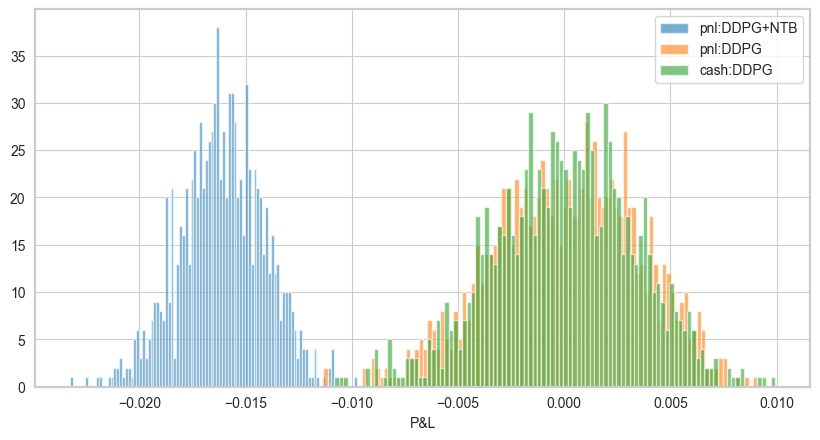

pnl:ntb pnl: 		[-0.0162 -0.0161  0.002 ]
pnl:rl pnl: 		[-0.      0.0001  0.0035]
cash:rl pnl: 		[-0.0001 -0.      0.0034]

pnl:ntb cvar:		0.02036
pnl:rl cvar:		0.00742
cash:rl cvar:		0.00731



In [30]:
plt_kwargs = {'bins': 100,
              # 'range': (-0.04, 0.01),
              'alpha': 0.6}

plt.xlabel('P&L')
plt.hist(pnl_ntb_pnl,**plt_kwargs, label='pnl:DDPG+NTB')
plt.hist(pnl_rl_pnl, **plt_kwargs, label='pnl:DDPG')
plt.hist(cash_rl_pnl, **plt_kwargs, label='cash:DDPG')
plt.legend()
plt.show()

print(f'pnl:ntb pnl: \t\t{np.round(pnl_reward(pnl_ntb_pnl), 4)}')
print(f'pnl:rl pnl: \t\t{np.round(pnl_reward(pnl_rl_pnl), 4)}')
print(f'cash:rl pnl: \t\t{np.round(pnl_reward(cash_rl_pnl), 4)}')
print()

print(f'pnl:ntb cvar:\t\t{cvar(pnl_ntb_pnl):.5f}')
print(f'pnl:rl cvar:\t\t{cvar(pnl_rl_pnl):.5f}')
print(f'cash:rl cvar:\t\t{cvar(cash_rl_pnl):.5f}')
print()

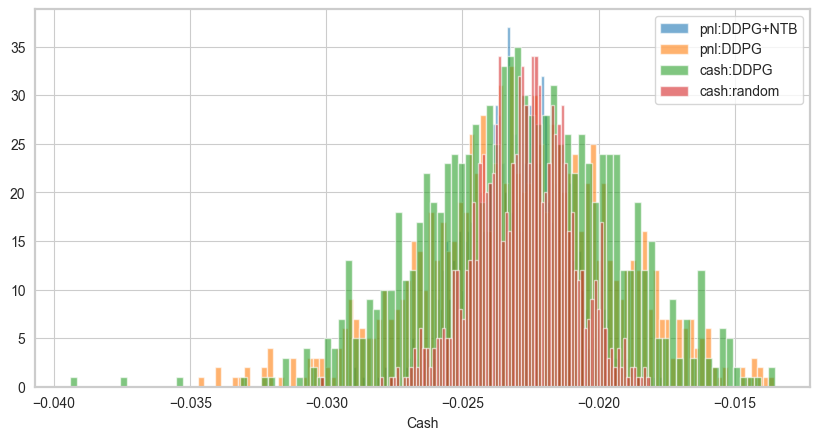

pnl:ntb cash: 		[-0.023  -0.023   0.0018]
pnl:rl cash: 		[-0.023  -0.0229  0.0035]
cash:rl cash: 		[-0.023  -0.0229  0.0035]
cash:random: 		[-0.0228 -0.0227  0.0017]

pnl:ntb cvar:		0.02667
pnl:rl cvar:		0.03066
cash:rl cvar:		0.03039
cash:random:		0.02649



In [34]:
plt_kwargs = {'bins': 100,
              # 'range': (-0.04, 0.01),
              'alpha': 0.6}

plt.xlabel('Cash')
plt.hist(pnl_ntb_cash, **plt_kwargs, label='pnl:DDPG+NTB')
plt.hist(pnl_rl_cash, **plt_kwargs, label='pnl:DDPG')
plt.hist(cash_rl_cash, **plt_kwargs, label='cash:DDPG')
plt.hist(random_cash, **plt_kwargs, label='cash:random')
plt.legend()
plt.show()

print(f'pnl:ntb cash: \t\t{np.round(pnl_reward(pnl_ntb_cash), 4)}')
print(f'pnl:rl cash: \t\t{np.round(pnl_reward(pnl_rl_cash), 4)}')
print(f'cash:rl cash: \t\t{np.round(pnl_reward(cash_rl_cash), 4)}')
print(f'cash:random: \t\t{np.round(pnl_reward(random_cash), 4)}')
print()

print(f'pnl:ntb cvar:\t\t{cvar(pnl_ntb_cash):.5f}')
print(f'pnl:rl cvar:\t\t{cvar(pnl_rl_cash):.5f}')
print(f'cash:rl cvar:\t\t{cvar(cash_rl_cash):.5f}')
print(f'cash:random:\t\t{cvar(random_cash):.5f}')
print()

In [47]:
def env_eval_action(env, model=None, reward_mode='cash'):
    tmp = env.reward_mode
    env.reward_mode = reward_mode
    obs = env.reset()
    reward, done, info = 0, False, {}
    total_raw_reward = 0
    actions = []
    for i in range(30):
        while not done:
            if model:
                action, _ = model.predict(obs, deterministic=False)
            else:
                action = env.action_space.sample()
            actions.append(action)
            obs, reward, done, info = env.step(action)

    env.reward_mode = tmp
    action_min = np.min(actions)
    action_max = np.max(actions)
    return np.mean(actions, axis=0), action_min, action_max

In [48]:
m_actions, m_min, m_max = env_eval_action(eval_env, model, 'cash')
r_actions, r_min, r_max = env_eval_action(eval_env, None, 'cash')

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


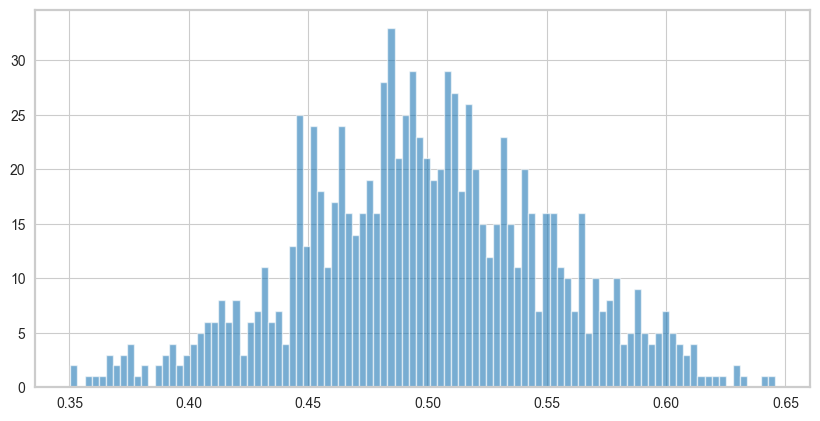

In [53]:
plt.hist(r_actions, **plt_kwargs)
plt.show()

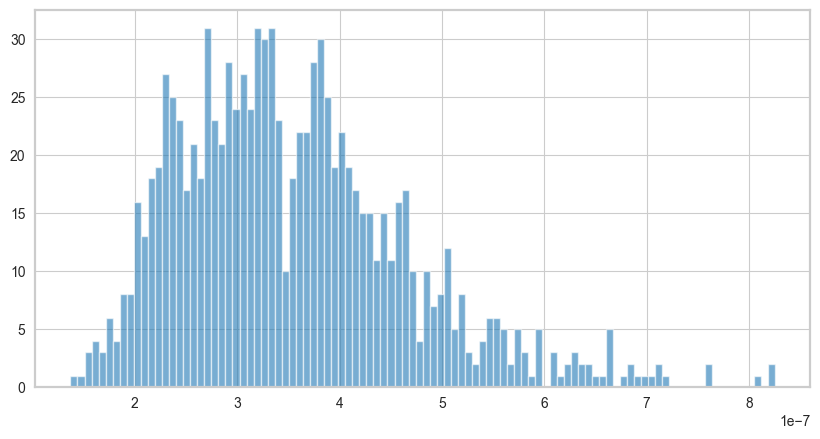

In [52]:
plt.hist(m_actions, **plt_kwargs)
plt.show()